# PROJEK AKHIR KECERDASAN BUATAN
## Pendeteksi Keretakan pada Bangunan

### Penjelasan Projek
Projek akhir ini membahas mengenai model kecerdasan buatan dalam mendeteksi kerusakan utama pada struktur bangunan khususnya keretakan pada tiap betonnya, dengan memainkan peran utama dalam inspeksi bangunan untuk menemukan retakan pada bangunan.

### Penjelasan Dataset
Kumpulan data yang berisikan gambar berbagai permukaan beton dengan 2 kondisi yang berbeda, yaitu retak dan tidak retak. Data citra tersebut kemudian dibagi menjadi 2 kelas berdasarkan kondisinya, yaitu negatif (tidak retak) dan positif (retak) ke dalam folder yang terpisah, yakni train dan test dengan perbandingan 9:1. Setiap kelasnya memiliki 20.000 gambar dengan total 40.0000 secara keseluruhan. Tiap-tiap gambar berukuran 227 x 227 pixel dengan penggunaan warna RGB. <br><br>
Sumber dataset: https://www.kaggle.com/datasets/arunrk7/surface-crack-detection

## Kelompok 4
AZIIZAH OKI SHOFRINA (2109106004) - <b> Ketua </b> <br> 
Jobdesk: Data Collecting, Data Preprocessing, Modelling, Evaluasi <br>

ALIYA IRFANI         (2109106007) <br>
Jobdesk: Data Analisis dan Visualisasi (visualisasi), Modelling, Evaluasi <br>

CHINTIA LIU WINTIN   (2109106008) <br>
Jobdesk: Data Analisis dan Visualisasi (metadata), Modelling, Evaluasi <br>

# Table of Contents

1. [Data Collecting](#1.-Data-Collecting) <br>
    A. [Training Set](#A.-Training-Set) <br> 
    B. [Validation Set](#B.-Validation-Set) <br>
    C. [Testing Set](#C.-Testing-Set) <br>
    
2. [Data Preprocessing](#2.-Data-Preprocessing) <br>
    A. [Brightness](#A.-Brightness) <br>
    B. [Hue](#B.-Hue) <br>
    C. [Saturation](#C.-Saturation) <br>
    D. [Grayscale](#D.-Grayscale) <br>
    E. [Contrast](#E.-Contrast) <br>
    F. [Normalisasi](#F.-Normalisasi) <br>
    G. [Standardisasi](#G.-Standardisasi) <br>
    
3. [Data Analisis dan Visualisasi](#3.-Data-Analisis-dan-Visualisasi) <br>
    A. [Metadata](#A.-Metadata) <br>
    B. [Visualisasi Dataset](#B.-Visualisasi-Dataset) <br>

4. [Data Modelling dan Evaluasi](#4.-Data-Modelling-dan-Evaluasi) <br>
    A. [Model Normalisasi RGB](#A.-Model-Normalisasi-RGB) <br>
    B. [Model Standardisasi RGB](#B.-Model-Standardisasi-RGB) <br>
    C. [Model Normalisasi Grayscale](#C.-Model-Normalisasi-Grayscale) <br>
    D. [Model Standardisasi Grayscale](#D.-Model-Standardisasi-Grayscale) <br>
    
5. [Kesimpulan](#5.-Kesimpulan)
6. [Save Model](#6.-Save-Model)

## Import Modul

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from PIL.ExifTags import TAGS
import exif

# 1. Data Collecting <a class="anchor" id="1.-Data-Collecting"></a>

## A. Training Set <a class="anchor" id="A.-Training-Set"></a>

In [2]:
train_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    subset="training",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 32400 files for training.


## B. Validation Set <a class="anchor" id="B.-Validation-Set"></a>

In [3]:
val_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    subset="validation",
    validation_split=0.1,
    batch_size=128
)

Found 36000 files belonging to 2 classes.
Using 3600 files for validation.


## C. Testing Set <a class="anchor" id="C.-Testing-Set"></a>

In [4]:
test_set = image_dataset_from_directory(
    "dataset/test",
    labels="inferred",
    label_mode="binary",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=False,
    batch_size=128
)

Found 4000 files belonging to 2 classes.


### Kelas yang Digunakan

In [5]:
classes = train_set.class_names
classes

['Negative', 'Positive']

### Shape Gambar dan Label

In [6]:
for images, labels in train_set.take(1):
    print(images.shape)
    print(labels.shape)
    break

(128, 64, 64, 3)
(128, 1)


### Preview Gambar

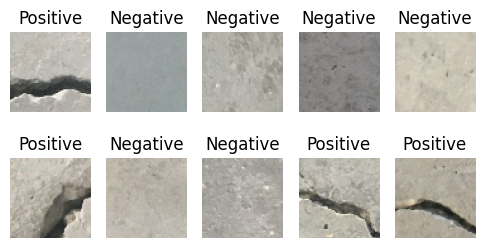

In [7]:
def preview_imgs(dataset):
    plt.figure(figsize=(6, 3))

    # ambil 1 batch
    for images, labels in dataset.take(1):
        
        # ambil 9 gambar
        for i in range(10):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
            plt.title("Negative" if labels[i].numpy()== 0 else "Positive")
            plt.axis("off")
            
preview_imgs(train_set)

### Sample Gambar

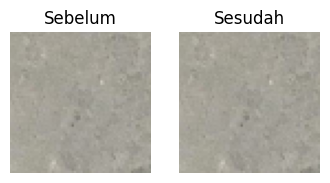

In [8]:
def sample_img(image1, image2):
    plt.figure(figsize=(4, 4))
    
    plt.subplot(1, 2, 1)
    plt.title("Sebelum")
    plt.imshow(image1.numpy().astype("uint8"), cmap="gray")
    plt.axis(False)
    
    plt.subplot(1, 2, 2)
    plt.title("Sesudah")
    plt.imshow(image2.numpy().astype("uint8"), cmap="gray")
    plt.axis(False)

# ambil 1 contoh gambar
for images, labels in train_set.take(1):
    ori_img = images[10]

sample_img(ori_img, ori_img)

# 2. Data Preprocessing

## A. Brightness
Sesuaikan kecerahan gambar

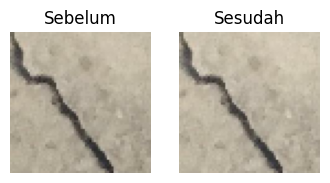

In [9]:
# ambil 1 contoh gambar
for images, labels in train_set.take(1):
    ori_img = images[10]

sample_img(ori_img, tf.image.random_brightness(ori_img, max_delta=10, seed=42))

### Sesuaikan kecerahan dataset gambar

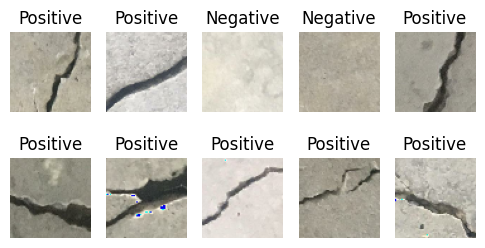

In [10]:
def brightness(x, y):
    image = tf.image.random_brightness(x, max_delta=10, seed=42)
    return image, y

b_train = train_set.map(brightness)
b_val = val_set.map(brightness)
b_test = test_set.map(brightness)

preview_imgs(b_train)

## B. Hue
Memberikan nuansa warna baru pada gambar

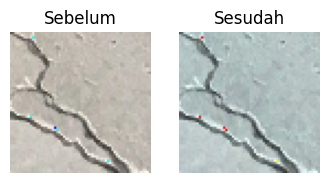

In [11]:
# ambil 1 contoh gambar
for images, labels in b_train.take(1):
    ori_img = images[11]

sample_img(ori_img, tf.image.random_hue(ori_img, max_delta=0.5, seed=42))

### Sesuaikan warna dataset gambar

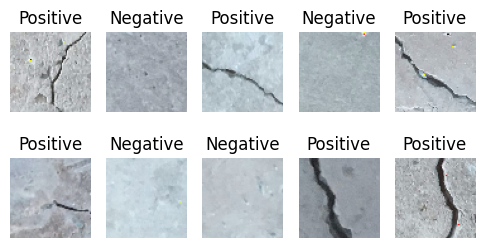

In [12]:
def hue(x, y):
    image = tf.image.random_hue(x, max_delta=0.5, seed=42)
    return image, y
    
hue_train = b_train.map(hue)
hue_val = b_val.map(hue)
hue_test = b_test.map(hue)

preview_imgs(hue_train)

## C. Saturation
Menyesuaikan insensitas warna. Semakin tinggi saturasi, semakin terang

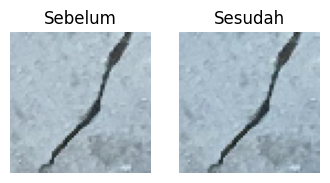

In [13]:
# ambil 1 contoh gambar
for images, labels in hue_train.take(1):
    ori_img = images[12]

sample_img(ori_img, tf.image.random_saturation(ori_img, 0.5, 1.5, seed=42))

### Sesuaikan saturasi dataset gambar

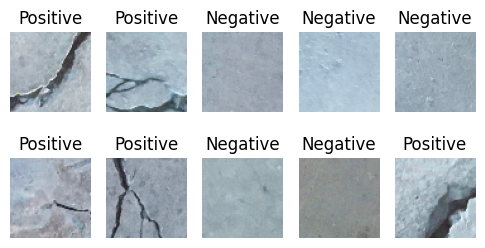

In [14]:
def saturate(x, y):
    image = tf.image.random_saturation(x, 0.5, 1.5, seed=42)
    return image, y
    
s_train = hue_train.map(saturate)
s_val = hue_val.map(saturate)
s_test = hue_test.map(saturate)

preview_imgs(s_train)

## D. Grayscale
Membuat gambar skala abu-abu

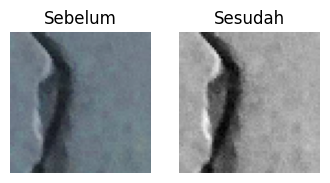

In [15]:
# ambil 1 contoh gambar
for images, labels in s_train.take(1):
    ori_img = images[13]

sample_img(ori_img, tf.image.rgb_to_grayscale(ori_img))

### Grayscaling dataset gambar

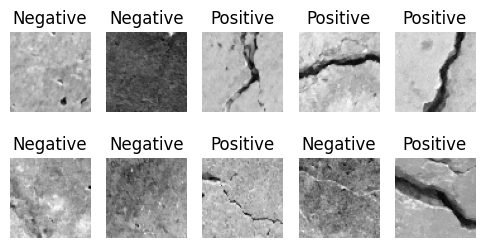

In [16]:
def grayscale(x, y):
    image = tf.image.rgb_to_grayscale(x)
    return image, y

g_train = train_set.map(grayscale)
g_val = val_set.map(grayscale)
g_test = test_set.map(grayscale)

preview_imgs(g_train)

### Shape Gambar Setelah Grayscaling

In [17]:
for image, label in g_train.take(1):
    print(image.numpy().shape)
    break

(128, 64, 64, 1)


## E. Contrast
Meningkatkan perbedaan antara bagian yang lebih cerah dan lebih gelap

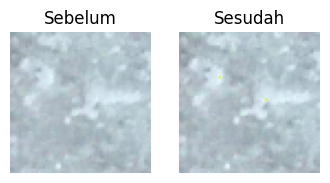

In [18]:
# ambil 1 contoh gambar
for images, labels in s_train.take(1):
    ori_img = images[21]
    
sample_img(ori_img, tf.image.random_contrast(ori_img, 1, 1.5, seed=42))

### Kontraskan dataset gambar RGB

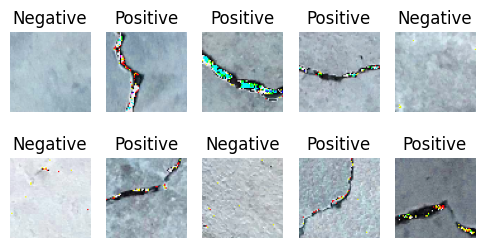

In [19]:
def contrast(x, y):
    image = tf.image.random_contrast(x, 1, 1.5, seed=42)
    return image, y

c_train_rgb = s_train.map(contrast)
c_val_rgb = s_val.map(contrast)
c_test_rgb = s_test.map(contrast)

preview_imgs(c_train_rgb)

### Kontraskan dataset gambar Grayscale

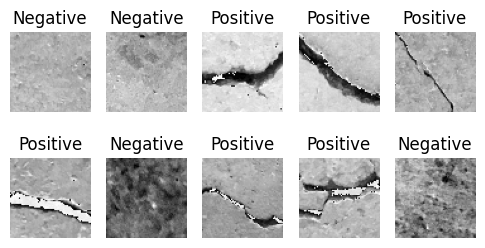

In [20]:
c_train_gray = g_train.map(contrast)
c_val_gray = g_val.map(contrast)
c_test_gray = g_test.map(contrast)

preview_imgs(c_train_gray)

## F. Normalisasi
Rescale gambar menjadi skala dalam rentang [0, 1]

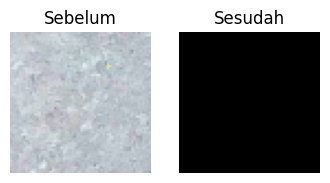

In [21]:
# ambil 1 contoh gambar
for images, labels in c_train_rgb.take(1):
    ori_img = images[17]

sample_img(ori_img, tf.keras.layers.Rescaling(1./255)(ori_img))

### Normalisasi dataset gambar RGB

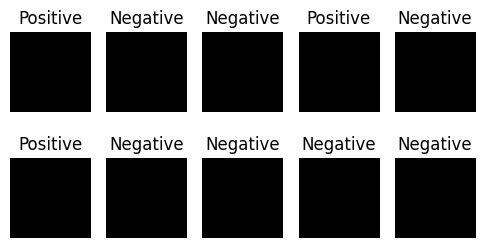

In [22]:
def normalize_img(x, y):
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    return normalization_layer(x), y

norm_train_rgb = c_train_rgb.map(normalize_img)
norm_val_rgb = c_val_rgb.map(normalize_img)
norm_test_rgb = c_test_rgb.map(normalize_img)

preview_imgs(norm_train_rgb)

### Normalisasi dataset gambar Grayscale

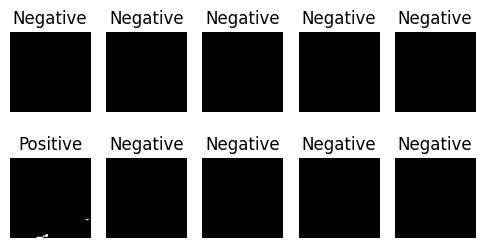

In [23]:
norm_train_gray = c_train_gray.map(normalize_img)
norm_val_gray = c_val_gray.map(normalize_img)
norm_test_gray = c_test_gray.map(normalize_img)

preview_imgs(norm_train_gray)

## G. Standardisasi
Standardisasi gambar sehingga memiliki rata-rata 0 dan varians 1

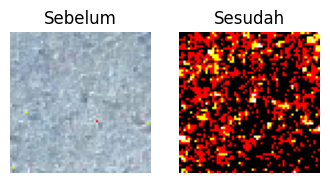

In [24]:
# ambil 1 contoh gambar
for images, labels in c_train_rgb.take(1):
    ori_img = images[20]

sample_img(ori_img, tf.image.per_image_standardization(ori_img))

### Standardisasi dataset gambar RGB

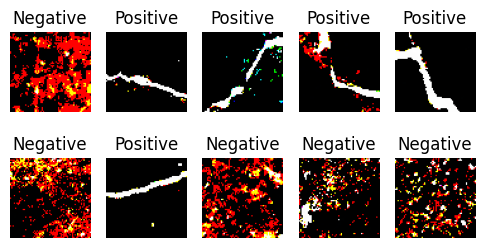

In [25]:
def standardization(x, y):
    image = tf.image.per_image_standardization(x)
    return image, y

std_train_rgb = c_train_rgb.map(standardization)
std_val_rgb = c_val_rgb.map(standardization)
std_test_rgb = c_test_rgb.map(standardization)

preview_imgs(std_train_rgb)

### Standardisasi dataset gambar Grayscale

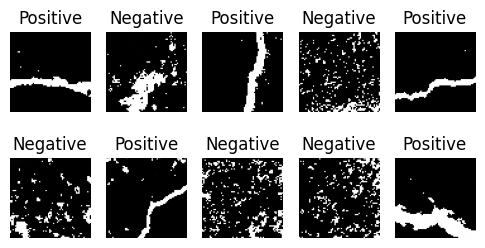

In [26]:
std_train_gray = c_train_gray.map(standardization)
std_val_gray = c_val_gray.map(standardization)
std_test_gray = c_test_gray.map(standardization)

preview_imgs(std_train_gray)

# 3. Data Analisis dan Visualisasi

## A. Metadata

In [27]:
nama_dataset = "Surface Crack Detection"
sumber = "https://www.kaggle.com/datasets/arunrk7/surface-crack-detection"
file = "0,01 MB"
imagename_neg = "dataset/train/Negative/02001.jpg"  # ambil sampel gambar negative
imagename_pos = "dataset/train/Positive/02001.jpg"  # ambil sampel gambar positive

### Cek Metadata Gambar

In [28]:
# cek apakah gambar punya metadata
with open(imagename_neg, 'rb') as image_file:
    image = exif.Image(image_file)

image.has_exif

False

### Tampilkan Info Dataset dan Metadata Gambar

In [29]:
image_pos = Image.open(imagename_pos)
image_neg = Image.open(imagename_neg)

print("Info Dataset")
print("Nama Dataset\t\t : ", nama_dataset,
      "\nSumber\t\t\t : ", sumber,
      "\nKelas\t\t\t : ", train_set.class_names,
      "\nJumlah Kelas\t\t : ", len(train_set.class_names),
      "\nUkuran Tiap Gambar\t : ", file,
      "\n")

# Melakukan Ekstrak pada Sample Gambar "Negative"
print("Sampel Gambar Negative")
info_dict_neg = {
    "Filename": image_neg.filename,
    "Image Size": image_neg.size,
    "Image Height": image_neg.height,
    "Image Width": image_neg.width,
    "Image Format": image_neg.format,
    "Image Mode": image_neg.mode,
    "Image is Animated": getattr(image_neg, "is_animated", False),
    "Frames in Image": getattr(image_neg, "n_frames", 1)
}
for label, value in info_dict_neg.items():
    print(f"{label:25}: {value}")
print()

# Melakukan Ekstrak pada Sample Gambar "Positive"
print("Sampel Gambar Positive")
info_dict_pos = {
    "Filename": image_pos.filename,
    "Image Size": image_pos.size,
    "Image Height": image_pos.height,
    "Image Width": image_pos.width,
    "Image Format": image_pos.format,
    "Image Mode": image_pos.mode,
    "Image is Animated": getattr(image_pos, "is_animated", False),
    "Frames in Image": getattr(image_pos, "n_frames", 1)
}
for label,value in info_dict_pos.items():
    print(f"{label:25}: {value}")


Info Dataset
Nama Dataset		 :  Surface Crack Detection 
Sumber			 :  https://www.kaggle.com/datasets/arunrk7/surface-crack-detection 
Kelas			 :  ['Negative', 'Positive'] 
Jumlah Kelas		 :  2 
Ukuran Tiap Gambar	 :  0,01 MB 

Sampel Gambar Negative
Filename                 : dataset/train/Negative/02001.jpg
Image Size               : (227, 227)
Image Height             : 227
Image Width              : 227
Image Format             : JPEG
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1

Sampel Gambar Positive
Filename                 : dataset/train/Positive/02001.jpg
Image Size               : (227, 227)
Image Height             : 227
Image Width              : 227
Image Format             : JPEG
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1


## B. Visualisasi Dataset

### Hitung Banyak Gambar dari Dataset

In [30]:
def len_dataset(dataset):
    n_dataset = 0
    n_neg_dataset = 0
    n_pos_dataset = 0
    for image, label in dataset.unbatch().as_numpy_iterator():
        n_dataset += 1
        
        if (label==0):
            n_neg_dataset += 1
        else:
            n_pos_dataset += 1

    return n_dataset, n_neg_dataset, n_pos_dataset

n_train, n_neg_train, n_pos_train = len_dataset(train_set)
n_val, n_neg_val, n_pos_val = len_dataset(val_set)
n_test, n_neg_test, n_pos_test = len_dataset(test_set)

print(f"Data Training   : {n_train}\
      \nData Validation : {n_val}\
      \nData Testing    : {n_test}")

Data Training   : 32400      
Data Validation : 3600      
Data Testing    : 4000


### Visualisasikan Dataset Berdasarkan Kelas

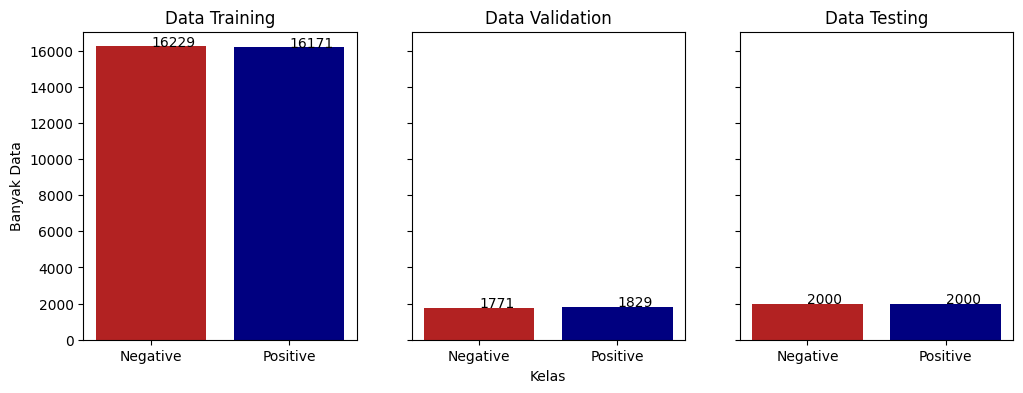

In [31]:
y1_train = n_neg_train
y2_train = n_pos_train

y1_val = n_neg_val
y2_val = n_pos_val

y1_test = n_neg_test
y2_test = n_pos_test

f, axes = plt.subplots(1, 3, figsize=(12, 4), sharey="row")

axes[0].set_title("Data Training")
axes[0].set_ylabel("Banyak Data")
axes[0].bar("Negative", y1_train, color='firebrick')
axes[0].bar("Positive", y2_train, color='navy')
axes[0].text("Negative", y1_train, str(y1_train))
axes[0].text("Positive", y2_train, str(y2_train))

axes[1].set_title("Data Validation")
axes[1].bar("Negative", y1_val, color='firebrick')
axes[1].bar("Positive", y2_val, color='navy')
axes[1].text("Negative", y1_val, str(y1_val))
axes[1].text("Positive", y2_val, str(y2_val))
axes[1].set_xlabel("Kelas")

axes[2].set_title("Data Testing")
axes[2].bar("Negative", y1_test, color='firebrick')
axes[2].bar("Positive", y2_test, color='navy')
axes[2].text("Negative", y1_test, str(y1_test))
axes[2].text("Positive", y2_test, str(y2_test))

plt.show()

# 4. Data Modelling dan Evaluasi

## A. Model Normalisasi RGB 

In [32]:
model_norm_rgb = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])

model_norm_rgb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 16)         0

In [33]:
model_norm_rgb.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Normalisasi RGB - Fitting Model

In [34]:
history_norm_rgb = model_norm_rgb.fit(
    norm_train_rgb,
    validation_data=norm_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 79s 308ms/step - loss: 0.1265 - accuracy: 0.9431 - val_loss: 0.0490 - val_accuracy: 0.9856
Epoch 2/10
254/254 [==============================] - 76s 299ms/step - loss: 0.0447 - accuracy: 0.9865 - val_loss: 0.0410 - val_accuracy: 0.9872
Epoch 3/10
254/254 [==============================] - 76s 299ms/step - loss: 0.0386 - accuracy: 0.9876 - val_loss: 0.0405 - val_accuracy: 0.9878
Epoch 4/10
254/254 [==============================] - 78s 305ms/step - loss: 0.0340 - accuracy: 0.9892 - val_loss: 0.0410 - val_accuracy: 0.9878
Epoch 5/10
254/254 [==============================] - 75s 293ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 0.0410 - val_accuracy: 0.9869
Epoch 6/10
254/254 [==============================] - 76s 298ms/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.0193 - val_accuracy: 0.9917
Epoch 7/10
254/254 [==============================] - 78s 306ms/step - loss: 0.0185 - accuracy: 0.9940 - val_loss: 0.0157 - val_ac

### Model Normalisasi RGB - Visualisasi Training Validation

In [35]:
def visualisasi_plot(model):
    epoch = [i+1 for i in range(10)]

    sns.set_theme()

    plt.figure(figsize=(11, 4))
    plt.suptitle("Train vs Validation")

    # grafik akurasi
    plt.subplot(1, 2, 1)
    plt.title("Accuracy")
    sns.lineplot(
        x=epoch,
        y=model.history["accuracy"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_accuracy"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy(%)")

    # grafik loss
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    sns.lineplot(
        x=epoch,
        y=model.history["loss"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_loss"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(%)")

    plt.show()

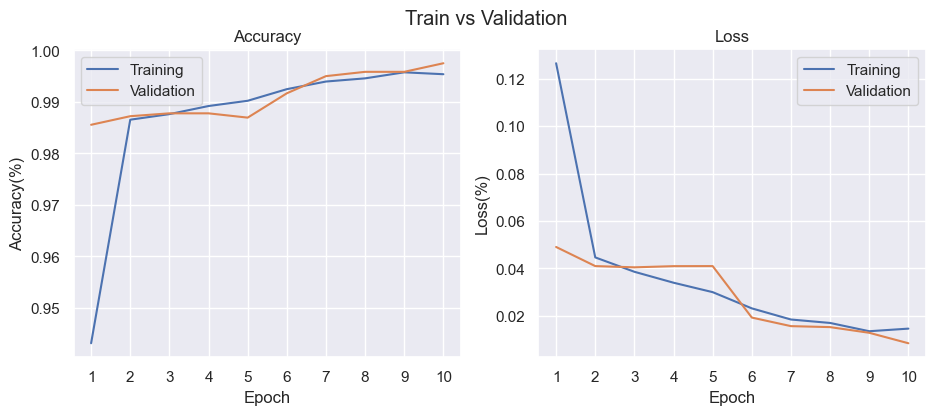

In [36]:
visualisasi_plot(history_norm_rgb)

### Model Normalisasi RGB - Evaluasi Testing

In [37]:
def evaluate_model(test_set, score, hasil_prediksi):
    print(
        f"Test Loss     : {score[0]}\
        \nTest Accuracy : {score[1]*100}%"
    )
    
    # Confusion Matrix
    labels = [label for image, label in test_set.unbatch()]

    cm = confusion_matrix(labels, hasil_prediksi)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Tidak Retak", "Retak"]
    )
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title("Evaluasi Testing")
    plt.grid(False)
    
    plt.show()

In [38]:
score_norm_rgb = model_norm_rgb.evaluate(norm_test_rgb)
prediksi_norm_rgb = (model_norm_rgb.predict(norm_test_rgb).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 3s 81ms/step


Test Loss     : 0.004605249036103487        
Test Accuracy : 99.90000128746033%


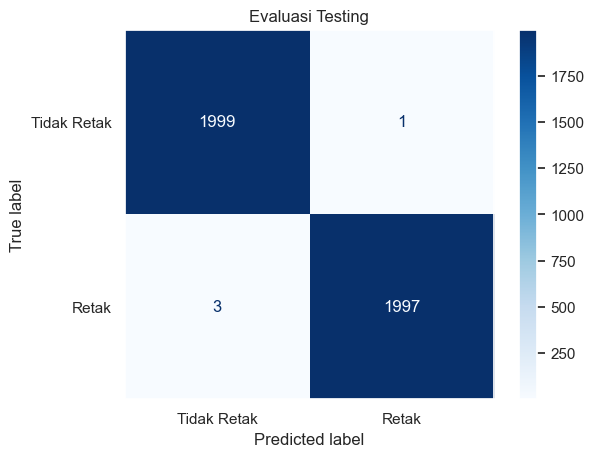

In [39]:
evaluate_model(norm_test_rgb, score_norm_rgb, prediksi_norm_rgb)

### Model Normalisasi RGB - Prediksi Test Set

In [40]:
def show_prediction(test_set, hasil_prediksi, mode=None):

    images = []
    labels = []
    labels_pred = []

    i = 0
    # simpan ke list
    for image, label in test_set.unbatch():
        
        if (mode == "normalize"):
            images.append((image.numpy()*255).astype("uint8"))
        else:
            images.append((image.numpy()).astype("uint8"))
            
        labels.append("Tidak Retak" if label == 0 else "Retak")
        labels_pred.append("Tidak Retak" if hasil_prediksi[i] == 0 else "Retak")
        i += 1

    plt.figure(figsize=(12, 4))

    # tampilkan 14 gambar prediksi
    for i in range(14):
        plt.subplot(2, 7, i+1)

        # ambil gambar acak
        index = randint(0, len(images))
        plt.imshow(images[index], cmap="gray")

        # label prediksi
        color = "green" if labels_pred[index] == labels[index] else "red"
        plt.title(f"{labels_pred[index]}", color=color)

        plt.axis("off")


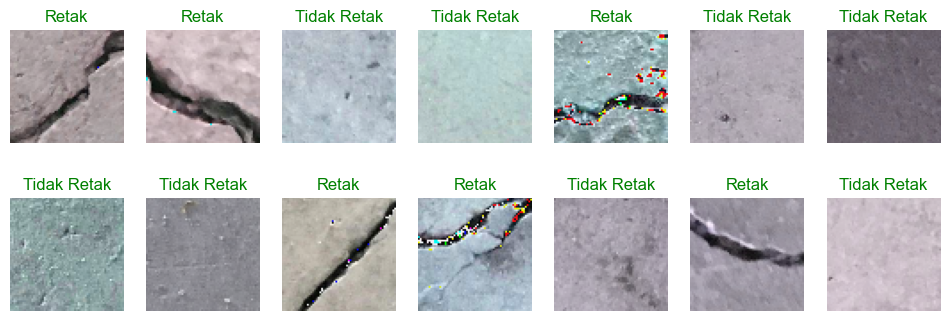

In [41]:
show_prediction(norm_test_rgb, prediksi_norm_rgb, mode="normalize")

### Model Normalisasi RGB - Kesalahan Prediksi Test Set

In [42]:
def show_mistakes(test_set, hasil_prediksi, mode=None):
    images = []
    labels = []
    labels_pred = []
    i=0
    
    for image, label in test_set.unbatch():

        # simpan hasil yang salah
        if (label != hasil_prediksi[i]):
            
            if (mode == "normalize"):
                images.append((image.numpy()*255).astype("uint8"))
            else:
                images.append((image.numpy()).astype("uint8"))
                
            labels.append("Tidak Retak" if label == 0 else "Retak")
            labels_pred.append("Tidak Retak" if hasil_prediksi[i] == 0 else "Retak")
        i+=1

    # tampilkan prediksi yang salah
    plt.figure(figsize=(12, 12))
    i=0
    for i in range(len(images)):
        plt.subplot(7, 7, i+1)
        plt.imshow(images[i], cmap="gray")
        plt.title(labels_pred[i], color="red")
        plt.axis("off")
        
    plt.show()
    

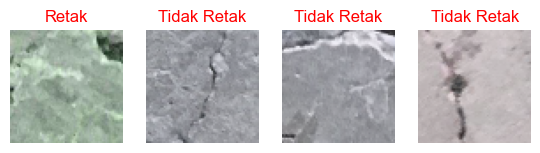

In [43]:
show_mistakes(norm_test_rgb, prediksi_norm_rgb, mode="normalize")

## B. Model Standardisasi RGB

In [44]:
model_std_rgb = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])

model_std_rgb.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 16)        

In [45]:
model_std_rgb.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Standardisasi RGB - Fitting Model

In [46]:
history_std_rgb = model_std_rgb.fit(
    std_train_rgb,
    validation_data=std_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 87s 340ms/step - loss: 0.0765 - accuracy: 0.9715 - val_loss: 0.0402 - val_accuracy: 0.9864
Epoch 2/10
254/254 [==============================] - 85s 335ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0661 - val_accuracy: 0.9783
Epoch 3/10
254/254 [==============================] - 81s 318ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0198 - val_accuracy: 0.9931
Epoch 4/10
254/254 [==============================] - 80s 315ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.0111 - val_accuracy: 0.9969
Epoch 5/10
254/254 [==============================] - 78s 304ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.0092 - val_accuracy: 0.9967
Epoch 6/10
254/254 [==============================] - 77s 303ms/step - loss: 0.0076 - accuracy: 0.9978 - val_loss: 0.0131 - val_accuracy: 0.9961
Epoch 7/10
254/254 [==============================] - 78s 305ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.0115 - val_ac

### Model Standardisasi RGB - Visualisasi Training Validation

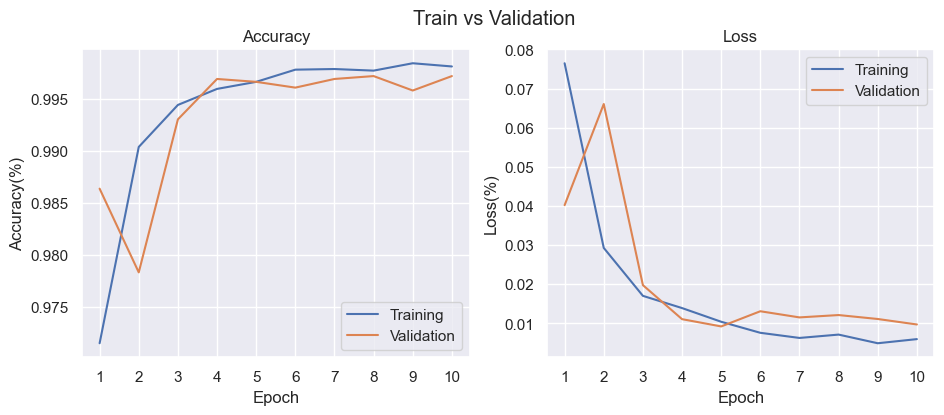

In [47]:
visualisasi_plot(history_std_rgb)

### Model Standardisasi RGB - Evaluasi Testing

In [48]:
score_std_rgb = model_std_rgb.evaluate(std_test_rgb)
prediksi_std_rgb = (model_std_rgb.predict(std_test_rgb).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 3s 84ms/step


Test Loss     : 0.011478470638394356        
Test Accuracy : 99.6999979019165%


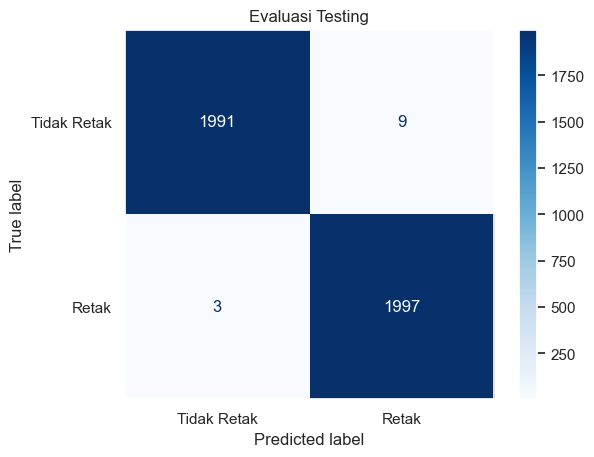

In [49]:
evaluate_model(std_test_rgb, score_std_rgb, prediksi_std_rgb)

### Model Standardisasi RGB - Prediksi Test Set

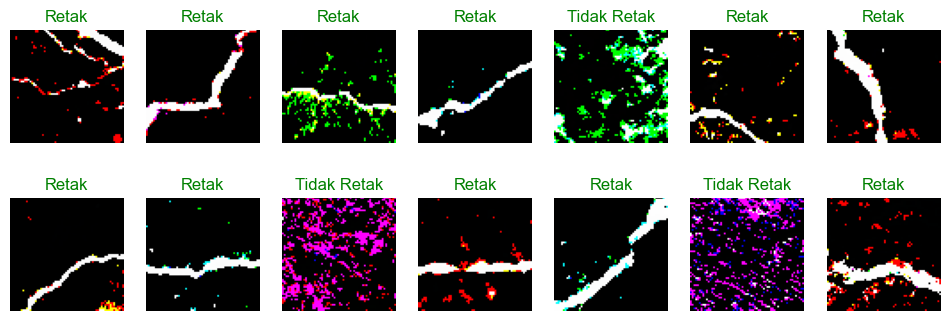

In [50]:
show_prediction(std_test_rgb, prediksi_std_rgb)

### Model Standardisasi RGB - Kesalahan Prediksi Test Set

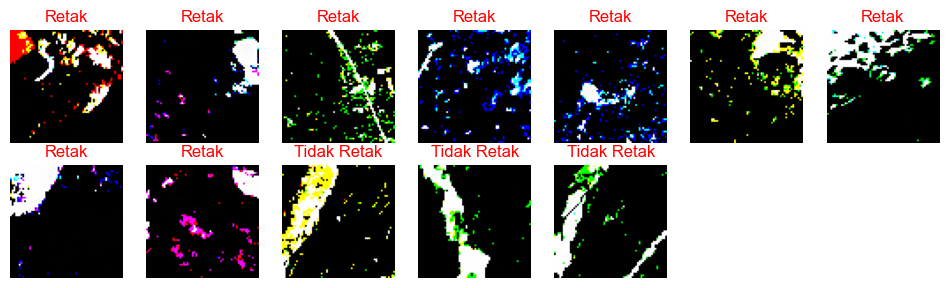

In [51]:
show_mistakes(std_test_rgb, prediksi_std_rgb)

## C. Model Normalisasi Grayscale

In [52]:
model_norm_gray = Sequential([
    Input((64, 64, 1)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])

model_norm_gray.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 16)        

In [53]:
model_norm_gray.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Normalisasi Grayscale - Fitting Model

In [54]:
history_norm_gray = model_norm_gray.fit(
    norm_train_gray,
    validation_data=norm_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 82s 319ms/step - loss: 0.1129 - accuracy: 0.9618 - val_loss: 0.0531 - val_accuracy: 0.9828
Epoch 2/10
254/254 [==============================] - 75s 294ms/step - loss: 0.0498 - accuracy: 0.9847 - val_loss: 0.0469 - val_accuracy: 0.9847
Epoch 3/10
254/254 [==============================] - 76s 296ms/step - loss: 0.0465 - accuracy: 0.9850 - val_loss: 0.0418 - val_accuracy: 0.9839
Epoch 4/10
254/254 [==============================] - 76s 296ms/step - loss: 0.0390 - accuracy: 0.9871 - val_loss: 0.0518 - val_accuracy: 0.9789
Epoch 5/10
254/254 [==============================] - 75s 294ms/step - loss: 0.0356 - accuracy: 0.9885 - val_loss: 0.0357 - val_accuracy: 0.9883
Epoch 6/10
254/254 [==============================] - 75s 294ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0306 - val_accuracy: 0.9875
Epoch 7/10
254/254 [==============================] - 78s 305ms/step - loss: 0.0294 - accuracy: 0.9905 - val_loss: 0.0223 - val_ac

### Model Normalisasi Grayscale - Visualisasi Training Validation

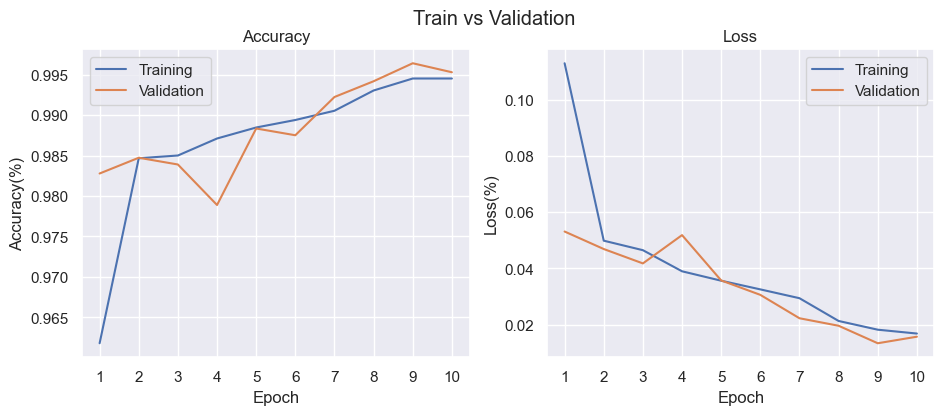

In [55]:
visualisasi_plot(history_norm_gray)

### Model Normalisasi Grayscale - Evaluasi Testing

In [56]:
score_norm_gray = model_norm_gray.evaluate(norm_test_gray)
prediksi_norm_gray = (model_norm_gray.predict(norm_test_gray).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 3s 84ms/step


Test Loss     : 0.010329160839319229        
Test Accuracy : 99.72500205039978%


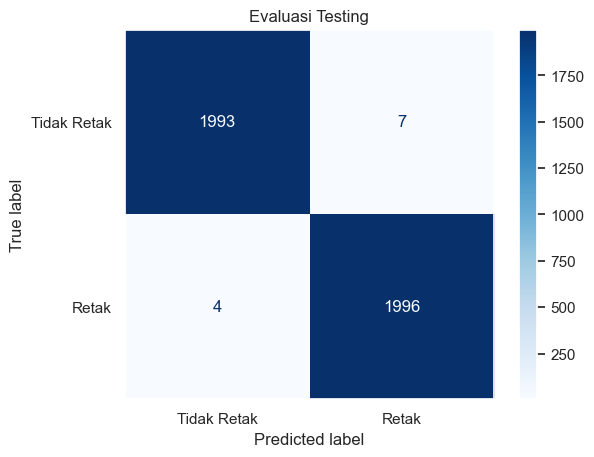

In [57]:
evaluate_model(norm_test_gray, score_norm_gray, prediksi_norm_gray)

### Model Normalisasi Grayscale - Prediksi Test Set

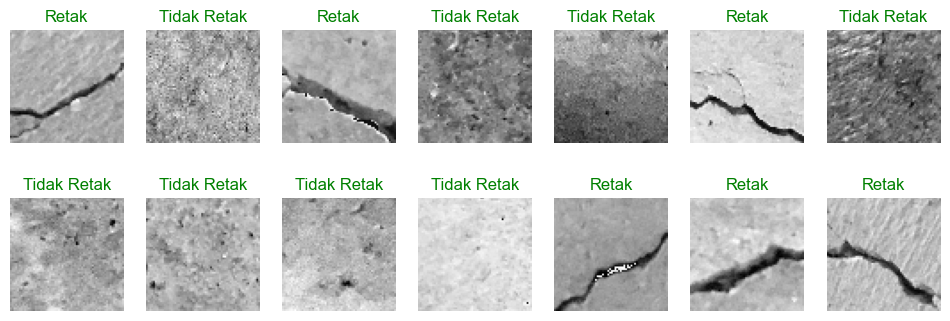

In [58]:
show_prediction(norm_test_gray, prediksi_norm_gray, mode="normalize")

### Model Normalisasi Grayscale - Kesalahan Prediksi Test Set

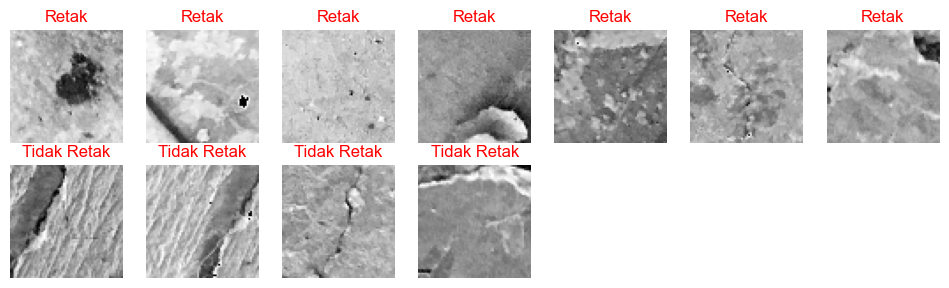

In [59]:
show_mistakes(norm_test_gray, prediksi_norm_gray, mode="normalize")

## D. Model Standardisasi Grayscale

In [60]:
model_std_gray = Sequential([
    Input((64, 64, 1)),
    
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    
    Dense(1, activation="sigmoid")
])
model_std_gray.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 16)        

In [61]:
model_std_gray.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Standardisasi Grayscale - Fitting Model

In [62]:
history_std_gray = model_std_gray.fit(
    std_train_gray,
    validation_data = std_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
254/254 [==============================] - 85s 332ms/step - loss: 0.0993 - accuracy: 0.9646 - val_loss: 0.0414 - val_accuracy: 0.9861
Epoch 2/10
254/254 [==============================] - 78s 306ms/step - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.0266 - val_accuracy: 0.9906
Epoch 3/10
254/254 [==============================] - 77s 302ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0173 - val_accuracy: 0.9947
Epoch 4/10
254/254 [==============================] - 78s 305ms/step - loss: 0.0134 - accuracy: 0.9962 - val_loss: 0.0185 - val_accuracy: 0.9958
Epoch 5/10
254/254 [==============================] - 78s 307ms/step - loss: 0.0101 - accuracy: 0.9969 - val_loss: 0.0179 - val_accuracy: 0.9958
Epoch 6/10
254/254 [==============================] - 77s 301ms/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0193 - val_accuracy: 0.9947
Epoch 7/10
254/254 [==============================] - 78s 304ms/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.0234 - val_ac

### Model Standardisasi Grayscale - Visualisasi Training Validation

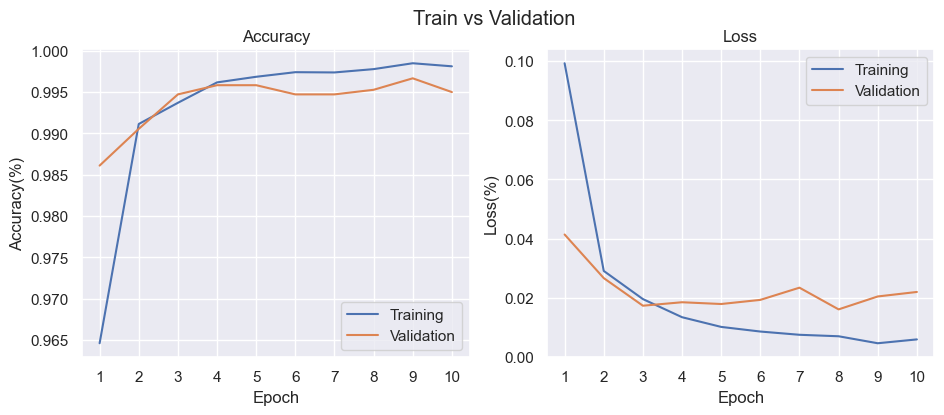

In [63]:
visualisasi_plot(history_std_gray)

### Model  Standardisasi Grayscale - Evaluasi Testing

In [64]:
score_std_gray = model_std_gray.evaluate(std_test_gray)
prediksi_std_gray = (model_std_gray.predict(std_test_gray).squeeze() >= 0.5).astype(int)

32/32 [==============================] - 3s 92ms/step


Test Loss     : 0.022742383182048798        
Test Accuracy : 99.34999942779541%


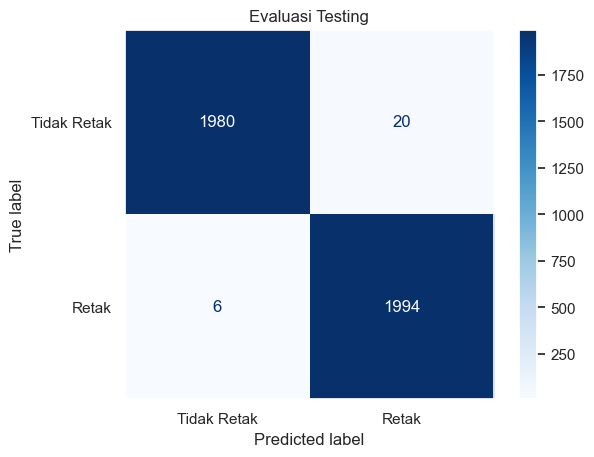

In [65]:
evaluate_model(std_test_gray, score_std_gray, prediksi_std_gray)

### Model Standardisasi Grayscale - Prediksi Test Set

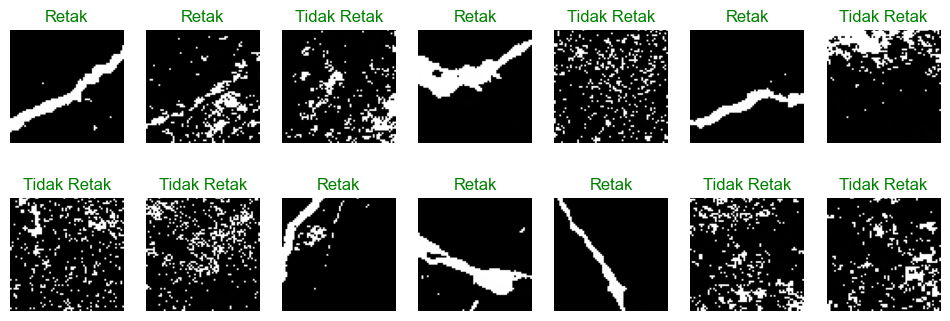

In [66]:
show_prediction(std_test_gray, prediksi_std_gray)

### Model  Standardisasi Grayscale - Kesalahan Prediksi Test Set

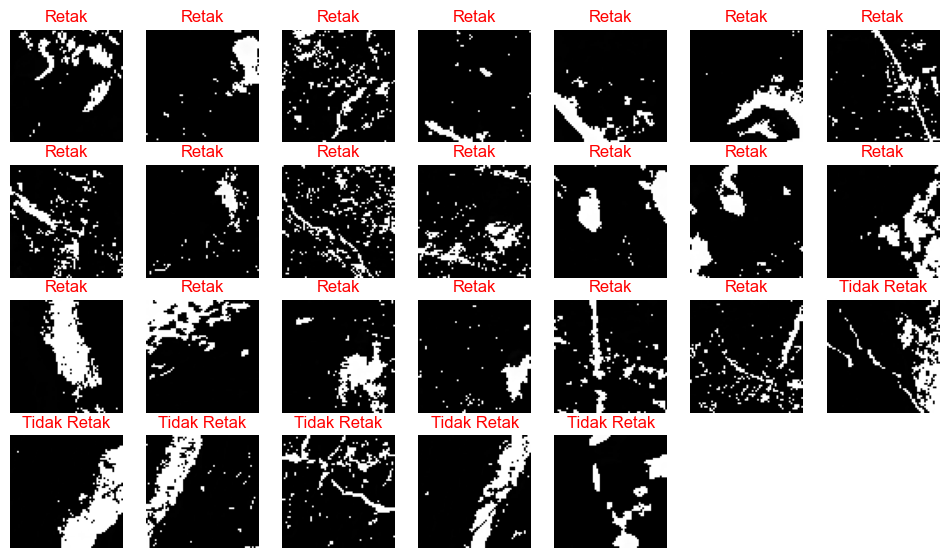

In [67]:
show_mistakes(std_test_gray, prediksi_std_gray)

# 5. Kesimpulan
Setelah dilakukan fitting model dari 4 data training berbeda, yakni
<ul>
    <li> Normalisasi RGB </li>
    <li> Normalisasi Grayscale </li>
    <li> Standardisasi RGB  </li>
    <li> Standardisasi Grayscale </li>
</ul>

Didapatkan hasil evaluasi sebagai berikut.

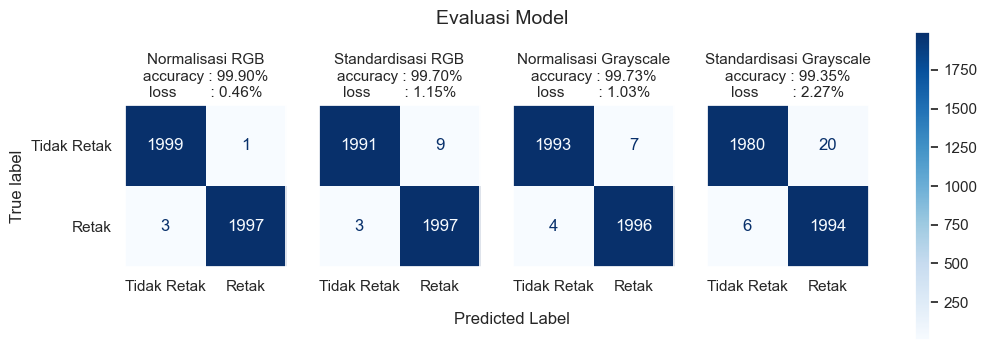

In [69]:
titles = ["Normalisasi RGB", "Standardisasi RGB", "Normalisasi Grayscale", "Standardisasi Grayscale"]
tests = [norm_test_rgb, std_test_rgb, norm_test_gray, std_test_gray]
scores = [score_norm_rgb, score_std_rgb, score_norm_gray, score_std_gray]
prediksi = [prediksi_norm_rgb, prediksi_std_rgb, prediksi_norm_gray, prediksi_std_gray]

f, axes = plt.subplots(1, 4, figsize=(12, 4), sharey="row")

for i in range(4):
    labels = [label for image, label in tests[i].unbatch()]
    
    # Confusion Matrix
    cm = confusion_matrix(labels, prediksi[i])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Tidak Retak", "Retak"]
    )
    
    disp.plot(ax=axes[i], cmap=plt.cm.Blues)
    disp.ax_.set_title(f"{titles[i]}\naccuracy : {scores[i][1]*100:.2f}%\nloss        : {scores[i][0]*100:.2f}%", fontsize=11)
    
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel("")
    if i > 0: disp.ax_.set_ylabel("")
    axes[i].grid(False)
    
f.text(0.4, 0.15, "Predicted Label", ha="left")
f.text(0.385, 0.9, "Evaluasi Model", ha="left", fontsize=14)
f.colorbar(disp.im_, ax=axes)
plt.show()

Jadi, model yang diambil adalah model yang memiliki 
<ul>
    <li> <b>ACCURACY</b> paling tinggi, yakni <b>99.90%</b> </li>
    <li> <b>LOSS</b> paling rendah, yakni <b>0.46%</b> </li>
</ul>
pada model yang menggunakan dataset RGB yang dinormalisasikan.

# 6. Save Model

In [71]:
model = model_norm_rgb

model.save("model.h5")

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)